In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

2024-06-16 19:13:27.137987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 19:13:27.138083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 19:13:27.253331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Analsing and Cleaning Dataset

In [3]:
# Read datasets
df_train = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', names=['Text', 'Emotion'], sep=';')

In [4]:
#print first 5 rows
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
#print the shape of the data set
print(df_train.shape)

(16000, 2)


In [6]:
#print first 5 rows
df_test.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [7]:
#print the shape of the data set
print(df_test.shape)

(2000, 2)


In [8]:
#print first 5 rows
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [9]:
#print the shape of the data set
print(df_val.shape)

(2000, 2)


In [10]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [11]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

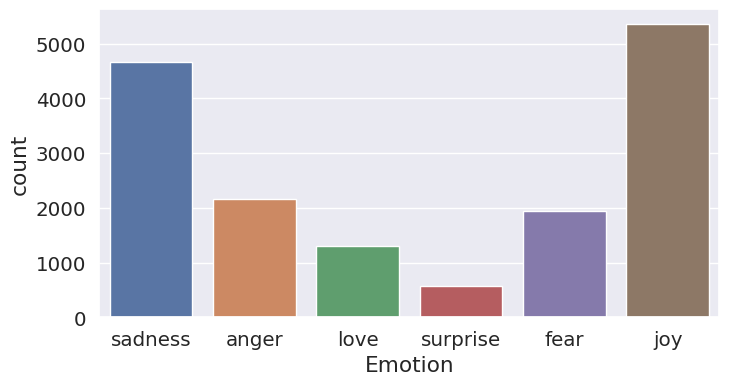

In [12]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [13]:
#print the number of null values in each column
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [14]:
#print the number of duplicated values 
df_train.duplicated().sum()

1

In [15]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [16]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [17]:
#removing duplicated text 
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [18]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

In [19]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [20]:
#print the number of null values in each column
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [21]:
#print the number of duplicated values 
df_test.duplicated().sum()

0

In [22]:
#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]

,Text,Emotion


In [23]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

In [24]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

In [25]:
#print the number of null values in each column
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [26]:
#print the number of duplicated values 
df_val.duplicated().sum()

0

In [27]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [28]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [29]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]

stop_words
7     190
5     175
8     173
3     160
6     160
10    150
9     146
4     145
2     133
11    103
Name: count, dtype: int64

### Compare rows of the datasets


check that there is no data leakage

In [30]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    # Return the filtered DataFrame
    return diff_df

In [31]:
dataframe_difference(df_train, df_test, which='both')

,Text,Emotion,_merge


In [32]:
dataframe_difference(df_train, df_val, which='both')

,Text,Emotion,_merge


In [33]:
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge


### Cleaning

In [34]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [35]:
normalized_sentence("My Name is Shaheer. @Tweets,  plays 2022  Pak_")

'name shaheer tweet play pak'

In [36]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

### Modeling

In [37]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [38]:

labels = pd.DataFrame(df_train['Emotion'])
labels.head()

,Emotion
0,sadness
1,sadness
2,anger
3,love
4,anger


In [39]:
labels.to_csv('labels.csv',index=False)

In [40]:
# Encode labels
le = LabelEncoder()
encoder = le.fit(y_train)
y_train = encoder.transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [41]:
#print the labels after encoding 
print(set(y_train))


{0, 1, 2, 3, 4, 5}


In [42]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [43]:
import pickle
with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


### Tokenizing

In [45]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [46]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

17969

In [47]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[53], [2], [531]]

In [48]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

(3, 14325)

In [50]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

### Padding
The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len

In [51]:
df_test.shape

(2000, 2)

In [52]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

229

In [53]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14325


In [54]:
#before
sequences_train[0]

[53, 2, 531]

In [55]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Word Embedding






**This code defines the following variables**:

**path_to_glove_file**: The file path to the GloVe word vectors file.

**num_tokens**: The size of the vocabulary. This is typically the number of unique words in the dataset.

**embedding_dim**: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

**hits**: A counter for the number of words that are found in the embeddings_index dictionary.

**misses**: A counter for the number of words that are not found in the embeddings_index dictionary.

**embeddings_index**: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [56]:
# Read GloVE embeddings

path_to_glove_file = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

I will intialize an embedding matrix with all zero values and then looping through the vocabulary (as defined by the tokenizer object) to assign word vectors to the corresponding rows of the embedding matrix. The word_index attribute of the tokenizer object is a dictionary that maps words to their indices in the vocabulary.

The embedding matrix will have a size of num_tokens rows and embedding_dim columns, where num_tokens is the size of the vocabulary and embedding_dim is the dimensionality of the word vectors.

For each word in the vocabulary, the code looks up the corresponding word vector in the embeddings_index dictionary and assigns it to the corresponding row of the embedding matrix. If the word is not found in the embeddings_index dictionary (i.e., if embedding_vector is None), the code increments the misses counter and the row of the embedding matrix remains all-zeros. If the word is found in the embeddings_index dictionary, the code increments the hits counter and assigns the word vector to the corresponding row of the embedding matrix. Finally, the code prints out the number of words that were converted (hits) and the number that were not found in the embeddings_index dictionary (misses).

In [57]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 13243 words (1081 misses)


In [58]:
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Modeling

The model consists of several layers:

An **Embedding layer** that takes in integer-encoded text and looks up the embedding vector for each word in the input. The input length is set to the length of the input sequences, and the weights are initialized with an embedding matrix that has been pre-trained on a large dataset. The embedding layer is not trainable, meaning that the weights of this layer will not be updated during training.

**Three Bidirectional layers**, each of which applies a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The dropout and recurrent dropout arguments specify the dropout rate to apply to the inputs and recurrent inputs of the LSTMs, respectively. The return_sequences argument specifies whether the LSTM should return the full sequences of outputs or just the last output of each sequence.

A **Dense layer** that applies a linear transformation to the input to produce the output. The output has 6 units and uses the 'softmax' activation function, which means that it will output a probability distribution over the 6 classes.

In [59]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,865,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,865,000 (10.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,865,000 (10.93 MB)

**This is the summary of a deep learning model built using the Keras functional API. The model consists of several layers, each of which has a specific type and number of parameters.**

The first layer is an "Embedding" layer, which takes in integer-encoded text and looks up the embedding vector for each word in the input. The output of this layer is a 3D tensor with shape (batch_size, sequence_length, embedding_dim), where batch_size is the number of examples in the batch, sequence_length is the length of the input sequences, and embedding_dim is the size of the embedding vectors. In this case, the input sequences are 229 words long and the embedding vectors are 200 dimensions. The embedding layer has a total of 2,863,600 trainable parameters.

The next three layers are "Bidirectional" layers, which apply a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The output of each bidirectional layer is a 3D tensor with shape (batch_size, sequence_length, units), where units is the number of LSTM units in the layer. In this case, the first bidirectional layer has 512 units, the second has 256 units, and the third has 256 units. Each of these layers has a large number of trainable parameters, as LSTMs are complex models with many internal weights.

The final layer is a "Dense" layer, which applies a linear transformation to the input to produce the output. In this case, the output has shape (batch_size, 6), indicating that there are 6 classes. The dense layer has a total of 1,542 trainable parameters.

Overall, the model has a total of 4,851,702 trainable parameters and 2,863,600 non-trainable parameters

In [60]:
input_shape = X_train.shape  
model.build(input_shape)

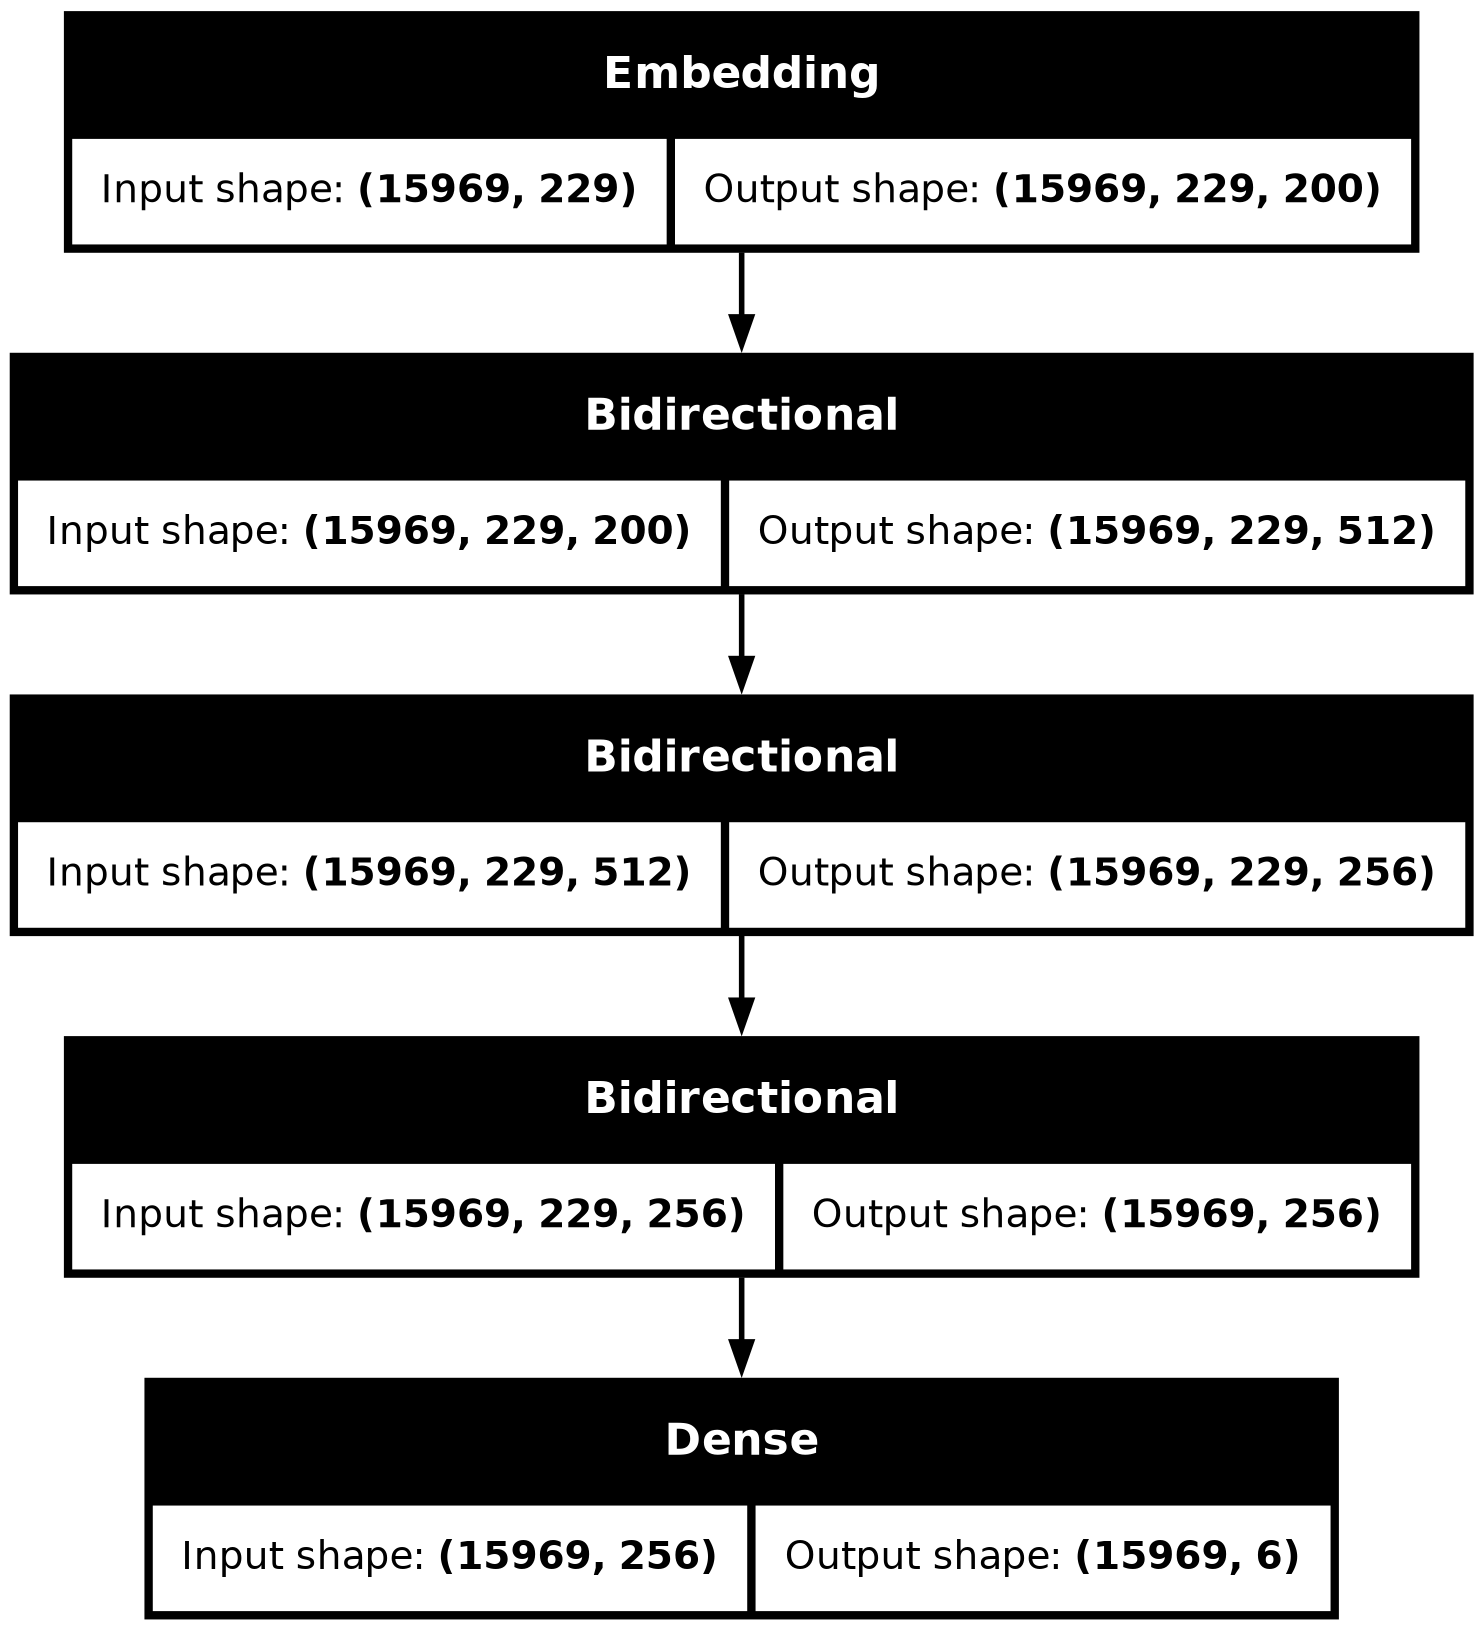

In [61]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [62]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [63]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.4303 - loss: 1.4517 - val_accuracy: 0.7643 - val_loss: 0.6541
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7971 - loss: 0.5710 - val_accuracy: 0.8934 - val_loss: 0.3094
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8943 - loss: 0.2892 - val_accuracy: 0.9199 - val_loss: 0.1908
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9264 - loss: 0.1781 - val_accuracy: 0.9319 - val_loss: 0.1530
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9373 - loss: 0.1349 - val_accuracy: 0.9384 - val_loss: 0.1278
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9477 - loss: 0.1149 - val_accuracy: 0.9284 - val_loss: 0.1325
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9478 - loss: 0.1057 - val_accuracy: 0.9294 - val_loss: 0.1311
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9500 - loss: 0.0976 - val_accuracy: 0.9349 - val_

In [64]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1) 

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 320ms/step - accuracy: 0.9382 - loss: 0.1207


[0.1278076022863388, 0.9384384155273438]

In [65]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1) 

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.9243 - loss: 0.1432


[0.14606623351573944, 0.9240000247955322]

In [66]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       275
           1       0.91      0.89      0.90       224
           2       0.95      0.93      0.94       695
           3       0.79      0.87      0.83       159
           4       0.97      0.96      0.96       581
           5       0.79      0.68      0.73        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.93      0.92      0.92      2000



In [67]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
joy : 0.8832380175590515


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
anger : 0.7137599587440491


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
anger : 0.34194573760032654


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
surprise : 0.6444028615951538




In [68]:
model.save('LSTM_emotion_model.h5')

In [69]:
!pip freeze > requirements.txt

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
